In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import tinyarray

## Define Graphene Lattice

In [2]:
glat = kwant.lattice.general([(1, 0), (np.cos(np.pi/3), np.sin(np.pi/3)   )], # the basis vectors
                             [(0, 0), (0         , 1/np.sqrt(3) )], # \vec r_A, \vec r_B
                             norbs=1)
alat, blat = glat.sublattices

In [3]:
def circle(pos, r = 10):
    x, y = pos
    return x*x + y*y < r*r

width = 1.
pot0 = 2.
def potential(site):
    x, y = site.pos
    d = y*np.sin(60) + x*np.cos(60)
    # d's contours are lines making 150 deg with the +x, it spans a line of a-b-a-b lattices
    return np.tanh(d/width) # the potential has a gradual (judging by the width) increase at d = 0

sys1 = kwant.Builder()
sys1[glat.shape(circle, (0, 0))] = potential

In [4]:
# define neighbors hoppings (neighbors() method can still be used)
# (0, 0), (0, 1) and (-1, 1) are vecs given in the preassigned basis vectors
hoppings = (((0, 0), alat, blat), ((0, 1), alat, blat), ((-1, 1), alat, blat)) 
sys1[(kwant.builder.HoppingKind(*hopping) for hopping in hoppings)] = -1.0

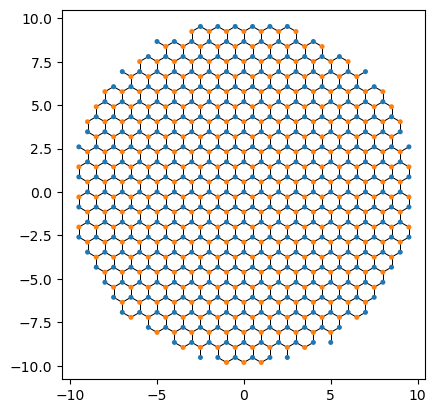

In [5]:
sys1[glat.neighbors()] = -1
kwant.plot(sys1)
plt.show()

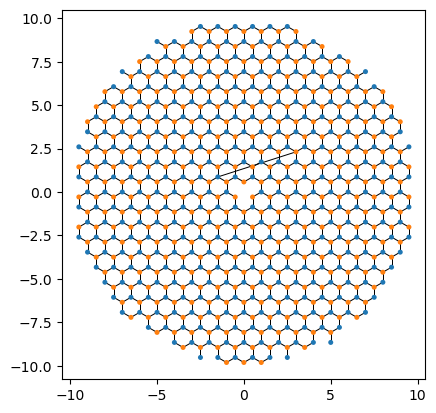

In [6]:
# Modify the scattering region
del sys1[alat(0, 0)]
sys1[alat(-2, 1), blat(2, 2)] = -1
kwant.plot(sys1)
plt.show()

In [7]:
# defining leads:
def lead_left(pos):
    x, y = pos
    r = 10
    return -0.4*r< y <0.4*r

lead1 = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))
lead1[glat.shape(lead_left, (0, 0))] = potential
lead1[glat.neighbors()] = -1.
# lead1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
def lead_up(pos):
    x, y = pos
    r = 10
    d = y*np.cos(np.pi/3) - x*np.sin(np.pi/3)
    return -0.4*r<d<0.4*r
lead2 = kwant.Builder(kwant.TranslationalSymmetry(glat.vec((0, 1))))
lead2[glat.shape(lead_up, (0, 0))] = potential
lead2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

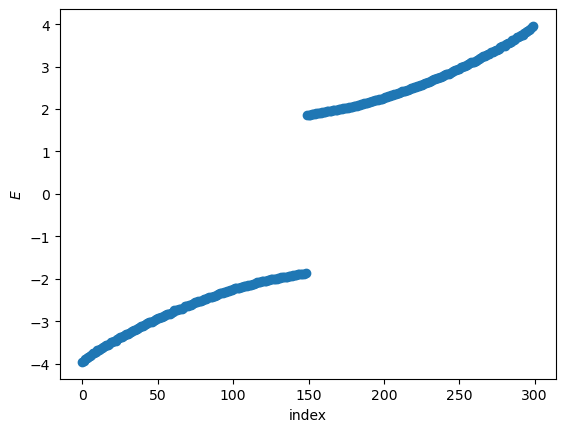

In [25]:
# calculating energies:
def get_energies(num_eigenstates, Bsystem: kwant.builder.FiniteSystem):
    Ham = Bsystem.hamiltonian_submatrix(sparse=True)
    es = sla.eigsh(Ham.tocsc(), k=num_eigenstates, return_eigenvectors=False, which='LM')
    plt.figure()
    plt.plot(np.sort(es), "o")
    plt.xlabel(r"index")
    plt.ylabel(r"$E$")

get_energies(300, sys1.finalized())

A clear Band gap is seen, its confinement Babe

In [22]:
def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    plt.figure()
    plt.plot(momenta, energies)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()

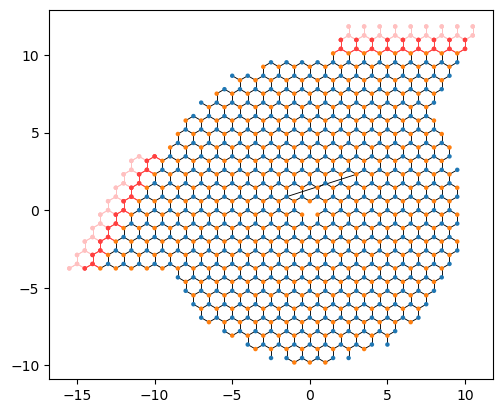

In [15]:
sys2 = sys1.__copy__()
sys2.attach_lead(lead1)
sys2.attach_lead(lead2)
kwant.plot(sys2)
plt.show()